# HW04: RDD and Diff-in-Diff (due 26th October)

**You will have to solve only one of the two parts (either the RDD or the DiD) to get full credit for this homework.**

In this homework you will investigate the causal effect in two different settings, applying different **identification strategies**, You will also reflect and investigate the identification assumptions that allow for a causal interpretation. 

## Regression Discontinuity Design

In this first part you will use data on mayors from municipalities in Brazil to invesitgate th effect of electoral accountability on corruption. The goal is to estimate the effect of being eligible for reelection (having reelection incentives) on misappropriation of resources exploiting random audits on municipalities before the elections. In Brazil there is a two mandate limit for mayors, implying that only mayors in the first mandate can be reelected. The reference paper is [Ferraz and Finan (2011)](https://www.aeaweb.org/articles?id=10.1257/aer.101.4.1274).

In [1]:
!pip install rdrobust

     |████████████████████████████████| 11.6 MB 856 kB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 38.1 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.6 MB 12.5 MB/s eta 0:00:01
     |████████████████████████████████| 7.2 MB 18.5 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 4.5 MB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 627 kB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 19.5 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=af0da97145a923f7273f924e743b2aed4d8314625a2b0cce949456a54080f889
  Stored in directory: /Users/hande/Library/Caches/pip/wheels/e4/7b/98/b6466d71b8d738a0c547008b9eb39bf8676d1ff6ca4b22af1c
Successfully built sklearn


In [4]:
from rdrobust import rdrobust, rdbwselect, rdplot
import pandas as pd 
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None


In [5]:
df = pd.read_stata('data/HW04_data_rdd.dta')

/opt/miniconda3/lib/python3.9/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [6]:
df_labels = pd.read_stata('data/HW04_data_rdd.dta', iterator=True).variable_labels()
df_labels

{'uf': 'state',
 'nsorteio': 'Número do sorteio',
 'totrecursos': 'Total de recurso fiscalizado no municipio',
 'tot_os': 'Total de OS fiscalizadas no municipio',
 'pop': 'População no ano de 2000',
 'purb': 'Proporção da população urbana no ano de 2000',
 'p_secundario': 'Proporção da população com 18 anos ou mais com secundario completo',
 'cod_ibge6': 'cod_ibge6',
 'pib_capita_02': 'PIB per capita deflacionado em reais de 2001',
 'op_01_04': 'Dummy se o munic teve orçamento participativo no periodo',
 'reeleito': 'Dummy de reeleição',
 'ENEP2000': '2000 ENEP',
 'ENLP2000': '2000 ENLP',
 'pref_idade_tse': 'Idade do prefeito',
 'comarca': 'Sede de Comarca',
 'reeleito_2004': 'Dummy dos candidatos que se reelegeram na eleição de 2004',
 'p_cad_pref': 'Proporção de vereadores eleitos do mesmo partido do prefeito',
 'rec_transf_correntes': '(mean) rec_transf_correntes',
 'gini_ipea': '',
 'fiscalizacoes': 'Total ordens de serviço dada pela planilha CGU',
 'valor_fiscalizado': 'Total orde

In [7]:
df = df[df['esample2']==1]
df.head()

,uf,nsorteio,totrecursos,tot_os,pop,purb,p_secundario,cod_ibge6,pib_capita_02,op_01_04,...,lfunc_ativ,lrec_fisc,ncorrupt,valor_corrupt,pcorrupt,dcorrupt,esample2,wm,winning_margin,party
0,RO,5,6913597.38,47.0,18207,0.815401,0.248250,566128.0,3548.000977,0,...,6.167517,15.749001,3.0,672785.125,0.097313,1.0,1.0,0.030935,-0.030935,16
1,RO,7,7135210.78,62.0,10459,0.198203,0.110925,566130.0,4203.421875,0,...,5.641907,15.780552,0.0,0.000,0.000000,0.0,1.0,0.172863,0.172863,3
2,RO,2,26821074.06,140.0,40884,0.649178,0.254702,566138.0,3904.267334,0,...,6.872128,17.104698,1.0,0.000,0.000000,1.0,1.0,0.310956,0.310956,18
3,RO,4,14710780.70,89.0,47382,0.726457,0.267212,566151.0,4081.257812,0,...,6.979145,16.504091,0.0,0.000,0.000000,0.0,1.0,0.391912,0.391912,18
4,RO,3,4181534.83,NaN,23874,0.271257,0.134546,566155.0,2192.473633,1,...,6.118097,15.246189,0.0,0.000,0.000000,0.0,1.0,0.186155,0.186155,14


The main outcome of interest is *pcorrupt*, namely, the share of audited resources found that involve corruption (a measure of misappropriation). The explanatory variable is *first*, a dummy variable indicating whether the mayor is in his first mandate. The regression of interest is the following: 

<center>$pcorrupt_i = \beta_0 + \beta_1 first_i + \varepsilon_i$</center>

In [15]:
## run the regression above using robust standard errors
import statsmodels.formula.api as smf 
from statsmodels.iolib.summary2 import summary_col

ols1 = smf.ols(formula = 'pcorrupt ~ first', data = df)

res = ols1.fit()

summary_col(res)

,pcorrupt
Intercept,0.0737
,(0.0071)
first,-0.0188
,(0.0094)
R-squared,0.0084
R-squared Adj.,0.0063


**What could be some sources of bias, namely, variables that act as confounder?**

'wm': 'vote margin',
'winning_margin': 'running variable',
pmismanagement
valor_corrupt

In [19]:
## run the regression above adding the variables that may act as a confounder
ols2 = smf.ols(formula = 'pcorrupt ~ first + wm + winning_margin + pmismanagement + valor_corrupt', data = df)

res2 = ols2.fit()


In [20]:
## display the results 
summary_col(res2)

,pcorrupt
Intercept,0.0455
,(0.0139)
first,-0.0262
,(0.0168)
wm,0.0114
,(0.0391)
winning_margin,-0.0264
,(0.0395)
pmismanagement,0.0078
,(0.0046)


**In your opinion, are there any additional sources of bias that threatens the causal interpretation of the results?**

To make sure that this is not the case we will use a regression discontinuity design where the running variable is the margin by which the incumbent won or lost in the previous election. Namely, we compare municipalities where incumbents won or lost by a narrow margin. This comparison provides quasi-random assignment of first-term and second-term mayors across these competitive elections.

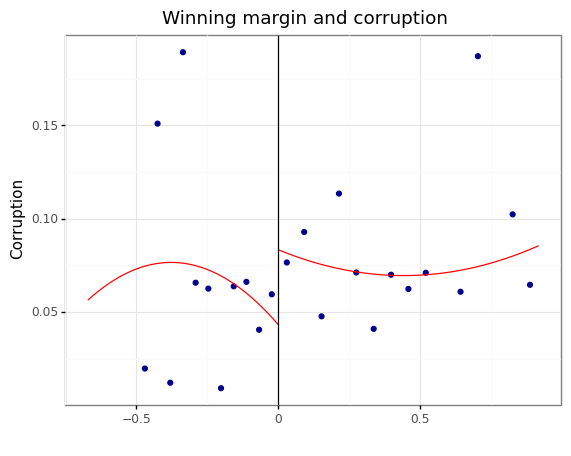


Call: rdplot
Number of Observations:                   328
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations           126        202
Number of Effective Obs          126        202
Bandwith poly. fit (h)         0.671      0.918
Number of bins scale               1          1
Bins Selected                     15         15
Average Bin Length             0.045      0.061
Median Bin Length              0.045      0.061
IMSE-optimal bins                5.0        3.0
Mimicking Variance bins         15.0       11.0

Relative to IMSE-optimal:
Implied scale                    3.0        5.0
WIMSE variance weight          0.036      0.008
WIMSE bias weight              0.964      0.992


In [22]:
## plot the RD plot using as running variable the variable winning_margin
## use a second order polynomial and 15 bins at each side

margin = df.dropna(subset=['winning_margin']).winning_margin
corruption = df.dropna(subset=['winning_margin']).pcorrupt
rdplot(y=corruption, x=margin, nbins=15, masspoints='adjust', p=2,
         title="Winning margin and corruption", 
         y_label="Corruption",
         x_label=" ")

In [44]:
## run the RD regression using the same dependent and explanatory variable as before
## include 4th degree polynomial and the covariates that you included above

covs = pd.concat([df[df['winning_margin']].first,  df[df['winning_margin']].wm, 
                   df[df['winning_margin']].pmismanagement], axis=1)

margin = df[df['winning_margin']].winning_margin
y = df[df['winning_margin']].pcorrupt
       
print(rdrobust(y=y, x=margin, covs=covs, p=4))

KeyError: "None of [Float64Index([-0.030934900045394897,   0.17286336421966553,\n                0.31095564365386963,   0.39191150665283203,\n                 0.1861552894115448,  -0.16741374135017395,\n                 0.4894978404045105,  -0.18018242716789246,\n                                nan,   0.17538461089134216,\n              ...\n                0.18476900458335876,                   nan,\n               -0.07983377575874329,  -0.07614737749099731,\n                0.03082457184791565,  0.013281494379043579,\n               -0.08926209807395935,    0.1882900893688202,\n                 0.6212095618247986,                   nan],\n             dtype='float64', length=476)] are in the [columns]"

## Difference-in-Differences

In this part you will use data from Argentina to investigate the causal effect of police on crime. Following the paper by [Di Tella and Schargrodsky (2004)](https://www.aeaweb.org/articles?id=10.1257/000282804322970733), you will exploit the follow-up of a terrorist attack tto the Jewish center in Buenos Aires in July 1994, after which all Jewish institution received police protection. This event induced a geographical allocation of police forces orthogonal to a crime regression allowing to isolate the causal effect of having more police in a neighborhood on a proxy for crime (car thefts), through a difference-in-differences analysis. 

In [ ]:
df = pd.read_stata('data/HW04_data_DiD.dta')
df_labels = pd.read_stata('data/HW04_data_DiD.dta', iterator=True).variable_labels()
df_labels

In [ ]:
df.head()

The main outcome of interest is *totrob*, the total number of car thefts (proxy for criminal activity). The main explanatory variable is a dummy variable indicating whether the there is a Jewish institution in the neighborhood **and** the observation is after July (*inst1p*). The main regression is the following: 

<center>$totrob_i = \beta_0 + \beta_1 inst1p_i + \varepsilon_i$</center>

In [ ]:
## Run the regression above with robust standard errors
import statsmodels.formula.api as smf

ols1 = ...

**Why this estimate CANNOT be interpreted as causal?**

In [ ]:
## Plot the time series of car thefts separately for blocks with and without a jewish institutions
## Add a vertical line indicating the terrorist attack 
import seaborn as sns
import matplotlib.pyplot as plt


**Does the parallel trend assumption hold?**

In [ ]:
##Run the regression above including month and block fixed effects
from linearmodels import PanelOLS
did = ...

In [ ]:
##show the results from both regressions

**Compare and interpret the results**